# PS2: Computing the Probability of Profit using Single Asset GBM models

[Geometric Brownian motion (GBM)](https://en.wikipedia.org/wiki/Geometric_Brownian_motion) is a continuous-time stochastic process model in which the random variable $S(t)$, e.g., the share price of `XYZ` is described by a deterministic drift corrupted by a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process):

$$\frac{dS}{S} = {\mu}dt + \sigma{dW}$$

The constant $\mu$ denotes a drift parameter, $\sigma$ indicates a volatility parameter, and $dW$ represents the output of a [Wiener process](https://en.wikipedia.org/wiki/Wiener_process).  Using [Ito's lemma](https://en.wikipedia.org/wiki/Itô%27s_lemma), we can formulate an analytical solution to the GBM equation:

$$S(t) = S_{\circ}\exp\Biggl[\left(\mu-\frac{\sigma^{2}}{2}\right)\left(t - t_{\circ}\right) + (\sigma\sqrt{t-t_{\circ}})\cdot{Z_{t}(0,1)}\Biggr]$$

where $S_{\circ}$ denotes the share price at $t_{\circ}$, and $Z_{t}(0,1)$ denotes a [standard normal random variable](https://en.wikipedia.org/wiki/Normal_distribution#Standard_normal_distribution) at time $t$.

## Learning objectives
This problem set will help students understand how to estimate the [cumulative distribution function](https://en.wikipedia.org/wiki/Cumulative_distribution_function) of fractional returns using the analytical solution to the geometric Brownian motion (GBM) model. By doing so, we can get an idea of the probability of achieving a specific fractional return within a set time frame based on a future predicted using the GBM model. 

## Setup

In [1]:
include("Include.jl");

### Packages
The `Include.jl` file loads several packages that we use'll for our exercises:
* [Dates.jl](https://docs.julialang.org/en/v1/stdlib/Dates/#Dates)  is a package included with the standard library which provides basic functionality for working dates.
* [DataFrames.jl](https://dataframes.juliadata.org/stable/) and [CSV.jl](https://github.com/JuliaData/CSV.jl) provide a set of tools for working with tabular data in [Julia](https://julialang.org). Its design and functionality are similar to those of [Pandas (in Python)](https://pandas.pydata.org) and [data.frame, data.table and dplyr (in R)](https://dplyr.tidyverse.org), making it an excellent general-purpose data science tool.
* [Distributions.jl](https://github.com/JuliaStats/Distributions.jl) is a [Julia](https://julialang.org) package for probability distributions and associated functions.
* [PrettyTables.jl](https://ronisbr.github.io/PrettyTables.jl/stable/man/html_backend/) is a [Julia](https://julialang.org) package that implements functions to construct and display text-based tables
* [Plots.jl](https://docs.juliaplots.org/stable/) is a plotting library, and [Colors.jl](https://github.com/JuliaGraphics/Colors.jl) is a color library that we'll use for data visualization in [Julia](https://julialang.org).
* [LinearAlgebra.jl](https://github.com/JuliaLang/LinearAlgebra.jl) is a package that provides functionality for working with linear algebra in [Julia](https://julialang.org).
* [Statistics.jl](https://docs.julialang.org/en/v1/stdlib/Statistics/#Statistics) is a package included with the standard library module, which contains basic statistics functionality

### Types
`Include.jl` loads some [problem-specific types](https://docs.julialang.org/en/v1/manual/types/#Composite-Types) that will be helpful for the geometric Brownian motion simulation of equity share prices.

The mutable struct `MyGeometricBrownianMotionEquityModel`, which holds the parameters associated with the geometric Brownian motion simulation, has two fields:
* The `μ::Float64` field holds the drift or growth parameter for the model
* The `σ::Float64` field holds the volatility parameter for the model

### Functions
The `Include.jl` file also loads the following [Julia functions](https://docs.julialang.org/en/v1/manual/functions/):

`function build(model::Type{MyGeometricBrownianMotionEquityModel}, data::NamedTuple) -> MyGeometricBrownianMotionEquityModel` 
> The `build)(...)` function takes information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument (the $(\mu, \sigma)$ values) and returns an instance of the `MyGeometricBrownianMotionEquityModel` [mutable type](https://docs.julialang.org/en/v1/manual/types/#Mutable-Composite-Types). 

`function sample(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple; number_of_paths::Int64 = 100) -> Array{Float64,2}`
> The `sample(...)` function takes a `MyGeometricBrownianMotionEquityModel` instance, and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and solves the geometric Brownian motion model for `number_of_paths` (default: 100) trials. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

`function 𝔼(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple) -> Array{Float64,2}`
> The `𝔼(...)` functions takes a `MyGeometricBrownianMotionEquityModel` instance and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and computes the expectation of the share price as a function of time. The expectation is returned as a `T`$\times$`2` array where the first column holds the time values while the second column holds the expected share price. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

`function Var(model::MyGeometricBrownianMotionEquityModel, data::NamedTuple) -> Array{Float64,2}`
> The `Var(...)` function takes a `MyGeometricBrownianMotionEquityModel` instance and information in the `data` [NamedTuple](https://docs.julialang.org/en/v1/base/base/#Core.NamedTuple) argument and computes the variance of the share price as a function of time. The variance is returned as a `T`$\times$`2` array where the first column holds the time values while the second column holds the share price variance. The `data` argument holds the initial share price `Sₒ::Float64`, the initial and final times for the simulation `T₁` and `T₂` respectively (both are `Float64` types), and the simulation time step `Δt::Float64`.

### Constants
Let's set some constant values that we will use below:

In [2]:
Δt = (1.0/252.0); # default timestep: 1-trading day in units of years
T = 48; # number of trading days for our projection
number_of_trading_days = 194; # number of trading days in the 2023 sample
number_of_sample_paths = 10000; # number of sample paths that we used to calculate to sample the model
all_range = range(1,stop=number_of_trading_days,step=1) |> collect; # range of possible time steps

### Setup the $\beta$-array
We'll simulate a range of perturbation values between a lower bound $\beta_{1}$ and an upper bound $\beta_{2}$, where we specify the number of test points between $\beta_{1}\rightarrow\beta_{2}$. We save this array in the `β` variable:

In [3]:
number_of_test_points = 100;
β₁ = 0.8;
β₂ = 1.2;
β = range(β₁,stop=β₂, length=number_of_test_points) |> collect;

### Prerequisite: Load GBM parameters and 2023 OHLC daily data
To test the model parameters we estimated in `Lab 7c`, we've downloaded a daily open-high-low-close `dataset` for each firm in the [S&P500](https://en.wikipedia.org/wiki/S%26P_500) for the 2023 year-to-date (`194` data points per firm). We filtered out firms that did not have complete data for the previous dataset. We load the 2023 price `dataset` by calling the `MyPortfolioDataSet()` function:

In [4]:
dataset = MyPortfolioDataSet() |> x-> x["dataset"]

Dict{String, DataFrame} with 486 entries:
  "NI"   => 194×8 DataFrame…
  "EMR"  => 194×8 DataFrame…
  "CTAS" => 194×8 DataFrame…
  "HSIC" => 194×8 DataFrame…
  "KIM"  => 194×8 DataFrame…
  "PLD"  => 194×8 DataFrame…
  "IEX"  => 194×8 DataFrame…
  "BAC"  => 194×8 DataFrame…
  "CBOE" => 194×8 DataFrame…
  "EXR"  => 194×8 DataFrame…
  "NCLH" => 194×8 DataFrame…
  "CVS"  => 194×8 DataFrame…
  "DRI"  => 194×8 DataFrame…
  "DTE"  => 194×8 DataFrame…
  "ZION" => 194×8 DataFrame…
  "AVY"  => 194×8 DataFrame…
  "EW"   => 194×8 DataFrame…
  "EA"   => 194×8 DataFrame…
  "NWSA" => 194×8 DataFrame…
  ⋮      => ⋮

In [5]:
dataset["NI"]

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,2.38552e6,27.3371,27.5,27.44,27.58,26.99,2023-01-03T05:00:00,18056
2,2.65499e6,27.772,27.59,27.78,27.995,27.57,2023-01-04T05:00:00,19643
3,2.67839e6,27.1658,27.49,27.13,27.6,27.09,2023-01-05T05:00:00,20277
4,3.37638e6,27.6004,27.42,27.61,27.8,27.37,2023-01-06T05:00:00,30729
5,6.11344e6,27.8869,27.59,27.88,28.075,27.53,2023-01-09T05:00:00,21417
6,5.88862e6,27.5128,27.83,27.56,27.86,27.23,2023-01-10T05:00:00,36784
7,3.71542e6,27.9417,27.61,27.93,28.12,27.61,2023-01-11T05:00:00,22715
8,3.17019e6,27.988,27.94,27.9,28.19,27.83,2023-01-12T05:00:00,22462
9,2.97715e6,27.8039,27.71,27.79,27.965,27.58,2023-01-13T05:00:00,19645


Later, we'll be picking a random ticker, so let's save a sorted collection of ticker symbols in the `list_of_firms` variable:

In [6]:
list_of_firms = keys(dataset) |> collect |> sort;

In [7]:
list_of_firms

486-element Vector{String}:
 "A"
 "AAL"
 "AAP"
 "AAPL"
 "ABBV"
 "ABC"
 "ABT"
 "ACN"
 "ADBE"
 "ADI"
 ⋮
 "XEL"
 "XOM"
 "XRAY"
 "XYL"
 "YUM"
 "ZBH"
 "ZBRA"
 "ZION"
 "ZTS"

#### Load parameters dataset
In addition, I've modified `Lab 7c` to save the estimated values for the drift and volatility parameters for each firm in our dataset. We load this data by calling the `MyFirmParametersDataSet()` function, and save these values in the `parameters` variable (which is type `DataFrame`):

In [8]:
parameters = MyFirmParametersDataSet()

Row,index,ticker,drift,volatility
,Int64,String7,Float64,Float64
1,1,MMM,-0.0822692,0.238729
2,2,AOS,0.0441975,0.266025
3,3,ABT,0.151149,0.230271
4,4,ABBV,0.118596,0.266743
5,6,ACN,0.178695,0.250005
6,7,ATVI,0.0745844,0.305086
7,8,ADM,0.161607,0.237929
8,9,ADBE,0.171392,0.307362
9,10,AAP,0.0890969,0.307218


## Task 1: Select a random firm, build a GBM model and simulate forward in time

In [9]:
random_firm_ticker = rand(list_of_firms)

"ORCL"

Now that we have a random firm ticker symbol, let's pull the data that corresponds to this ticker from the `dataset`, and save this in the `random_firm_data` variable (which is type `DataFrame`):

In [10]:
random_firm_data = dataset[random_firm_ticker]

Row,volume,volume_weighted_average_price,open,close,high,low,timestamp,number_of_transactions
,Float64,Float64,Float64,Float64,Float64,Float64,DateTime,Int64
1,8.99753e6,83.1928,82.47,83.72,83.84,82.26,2023-01-03T05:00:00,87854
2,7.83624e6,84.4708,84.2,84.48,85.17,83.64,2023-01-04T05:00:00,85369
3,7.64378e6,84.047,85.0,84.31,85.4,83.22,2023-01-05T05:00:00,78010
4,8.6416e6,85.6084,84.74,85.66,86.34,83.82,2023-01-06T05:00:00,77514
5,7.51984e6,86.8337,86.84,86.42,87.59,86.16,2023-01-09T05:00:00,84468
6,5.70327e6,86.2702,85.64,86.5,86.61,85.57,2023-01-10T05:00:00,63617
7,8.35967e6,87.9632,87.37,88.6,88.66,87.09,2023-01-11T05:00:00,72914
8,6.0711e6,88.7468,88.7,88.78,89.195,88.17,2023-01-12T05:00:00,72615
9,5.09094e6,88.8042,87.95,89.2,89.4662,87.66,2023-01-13T05:00:00,60511


In addition, let's pull the estimated values for the drift and volatility parameters from the `parameters` data structure, see the [filter command](https://dataframes.juliadata.org/stable/lib/functions/#Base.filter) exported by the [DataFrames.jl](https://github.com/JuliaData/DataFrames.jl.git) package for help with the syntax:

In [11]:
μ̂ = filter(:ticker=> x-> x == random_firm_ticker, parameters) |> x-> x[1,:drift]
σ̂ = filter(:ticker=> x-> x == random_firm_ticker, parameters) |> x-> x[1,:volatility];
println("Ticker $(random_firm_ticker) has (μ,σ) = ($(μ̂),$(σ̂))")

Ticker ORCL has (μ,σ) = (0.13155955973608763,0.24022281370746046)


Next, let's randomly choose a contiguous time window of `T` days and analyze the model’s performance during this period. To begin, we will generate the `start_index` variable, i.e., the trading index to start the simulation from. The `stop_index` will then be determined by adding the number of trading days `T` to the `start_index`:

In [12]:
start_index = rand(1:(number_of_trading_days - T - 1))
stop_index = start_index + T
println("Simulate Firm-$(random_firm_ticker) between trading days ($(start_index) -> $(stop_index))")

Simulate Firm-ORCL between trading days (104 -> 152)


Finally, let's create a geometric Brownian motion model, using the `build(…)` function and then solve it between `T₁` and `T₂` starting with price `Sₒ` using the `solve(…)` function. 
* In addition to the analytical values of the expectation and the variance, our simulation generates `N = 100` sample paths using the `sample(...)` function, where the resulting price values are saved in the `X` array. This array will be a `T`$\times$`N+1` array,  each row corresponds to a time value, while each column (after the first) is a solution:

In [13]:
model = build(MyGeometricBrownianMotionEquityModel, (
            μ = μ̂, σ = σ̂ ));

Sₒ = random_firm_data[start_index, :volume_weighted_average_price];
T₁ = start_index*Δt
T₂ = stop_index*Δt
X = sample(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt), 
    number_of_paths = number_of_sample_paths);

In [14]:
X

49×10001 Matrix{Float64}:
 0.412698  105.749  105.749  105.749  105.749  …  105.749  105.749   105.749
 0.416667  104.189  107.445  106.22   107.266     106.369  104.723   107.233
 0.420635  103.379  109.528  106.115  108.193     104.651  103.516   106.507
 0.424603  102.355  109.198  105.771  110.997     103.892  100.55    104.698
 0.428571   99.791  109.252  107.655  110.466     102.528  101.891   107.941
 0.43254   100.875  107.838  107.224  110.753  …  100.339  102.725   109.571
 0.436508  100.566  104.873  107.841  111.727     102.201  100.626   112.678
 0.440476  100.435  105.438  109.308  111.677     103.566  100.112   111.716
 0.444444  101.985  107.573  111.294  109.71      105.255   98.2286  110.514
 0.448413  103.909  107.766  112.369  109.983     104.908   97.0875  109.147
 ⋮                                             ⋱                       ⋮
 0.571429  112.814  110.808  128.751  107.197  …  109.33   100.285    91.477
 0.575397  112.995  109.992  129.063  109.043     110.

For Geometric Brownian Motion (GBM) analytical expressions are available for both the expected value and the variance of the share price. The expected share price is given by:

$$\mathbb{E}\left(S_{t}\right) = S_{o}\exp\left(\mu\cdot\Delta{t}\right)$$

where $\Delta{t} = t-t_{o}$ and $S_{o}$ denotes the share price at $t=t_{o}$. On the other hand the variance of the share price $\text{Var}(S_{t})$ at time $t$ is given by:

$$\text{Var}\left(S_{t}\right) = S_{\circ}^{2}e^{2\mu\cdot\Delta{t}}\left[e^{\sigma^{2}{\Delta{t}}} - 1\right]$$

We've implmented the analytical expectation and variance calculations in the `𝔼(...)` and `Var(...)` functions:

In [15]:
expectation = 𝔼(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));
variance = Var(model, (Sₒ = Sₒ, T₁ = T₁, T₂ = T₂, Δt = Δt));

#### Visualize

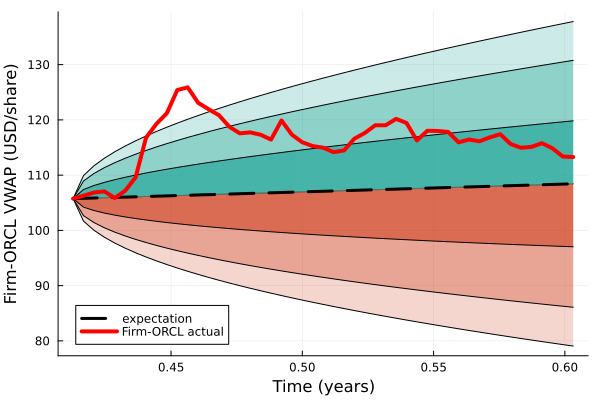

In [16]:
let
    L68 = expectation[:,2] .- sqrt.(variance[:,2])
    U68 = expectation[:,2] .+ sqrt.(variance[:,2])
    L95 = expectation[:,2] .- 1.96*sqrt.(variance[:,2])
    U95 = expectation[:,2] .+ 1.96*sqrt.(variance[:,2])
    L99 = expectation[:,2] .- 2.576*sqrt.(variance[:,2])
    U99 = expectation[:,2] .+ 2.576*sqrt.(variance[:,2])

    plot(X[:,1],X[:,2:end], label="", c=colors[2], alpha=0.1)
 
    plot(expectation[:,1], expectation[:,2], fillrange=L68, c=colors[5], alpha=0.5, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U68, c=colors[6], alpha=0.5, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L95, c=colors[5], alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U95, c=colors[6], alpha=0.3, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=L99, c=colors[5], alpha=0.2, label="")
    plot!(expectation[:,1], expectation[:,2], fillrange=U99, c=colors[6], alpha=0.2, label="")

    plot!(expectation[:,1], expectation[:,2],c=:black, lw=3,ls=:dash, label="expectation")
    plot!(expectation[:,1], L68, c=:black, lw=1, label="")
    plot!(expectation[:,1], U68, c=:black, lw=1, label="")
    plot!(expectation[:,1], L95, c=:black, lw=1, label="")
    plot!(expectation[:,1], U95, c=:black, lw=1, label="")
    plot!(expectation[:,1], L99, c=:black, lw=1, label="")
    plot!(expectation[:,1], U99, c=:black, lw=1, label="")
    
    plot!(X[:,1], random_firm_data[start_index:stop_index, :volume_weighted_average_price], lw=4, c=:red, 
        label="Firm-$(random_firm_ticker) actual")
   
    xlabel!("Time (years)", fontsize=18)
    ylabel!("Firm-$(random_firm_ticker) VWAP (USD/share)", fontsize=18)
end

## TODO: Compute the cumulative distribution function at `T`
The cumulative distribution function $F_{X}(x)$ is defined as the probability that a random variable $X$ is less that or equal to a value $x$, i.e.,

$$
\begin{equation}
F_{X}(x) = P(X\leq{x})
\end{equation}
$$

This tells us the probability that our fractional return is less than a specified value, and $1 - F_{X}(x)$ tells us $P(X>x)$. 

We generated an array of samples using the geometric Brownian motion model, use this data to estimate the cumulative distribution function $F_{X}(x)$ for the fractional return of the random selected firm. Store these values in the `cumulative_probability` array; this is a `number_of_test_points` $\times$ `3` array where:

* `col 1` holds the fractional fraction return
* `col 2` holds an estimate of $P(X\leq{x})$
* `col 3` holds an estimate of $P(X>x)$

In [34]:
Y = X[end,2:end]; # last row of the sample array - what does this correspond to?
cumulative_probability = Array{Float64,2}(undef, number_of_test_points, 3);
 for i ∈ eachindex(β)
    β_value = β[i]
    test_value = Sₒ*β_value;
    N = 0 
    for j ∈ 1:number_of_sample_paths
      if (Y[j]<= test_value)
         N +=1
      end
   end
 cumulative_probability[i,1]= β_value-1;
 cumulative_probability[i,2]=N/number_of_sample_paths;
 cumulative_probability[i,3]=1-N/number_of_sample_paths;
    

 end

In [35]:
Y = X[end,2:end];
cumulative_probability = Array{Float64,2}(undef, number_of_test_points, 3);
for i ∈ eachindex(β)
    β_value = β[i]
    
    test_value = Sₒ*β_value;
    N₊ = 0;
    for j ∈ 1:number_of_sample_paths
        
        if (Y[j] <= test_value)
            N₊ += 1
        end
    end
    
    # compute the postive frequency 
    cumulative_probability[i,1] = ((test_value - Sₒ)/(Sₒ));
    cumulative_probability[i,2] = N₊/number_of_sample_paths;
    cumulative_probability[i,3] = 1 - N₊/number_of_sample_paths;
end

### Visualize

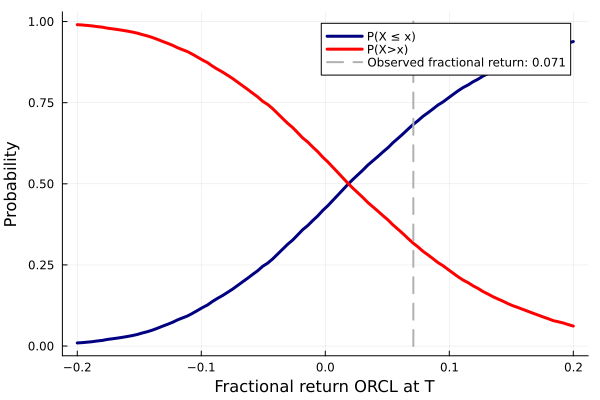

In [25]:
p = plot();
if (findall(x-> x!= 0.0,cumulative_probability) |> isempty == false)
    actual_close_vwap = random_firm_data[stop_index, :volume_weighted_average_price];
    actual_frac_return = ((actual_close_vwap - Sₒ)/Sₒ) |> x-> round(x,digits=3)
    plot!(cumulative_probability[:,1], cumulative_probability[:,2], c=:navyblue, lw=3, label="P(X ≤ x)")
    plot!(cumulative_probability[:,1], cumulative_probability[:,3], c=:red, lw=3, label="P(X>x)")
    VLINE = zeros(number_of_test_points,2);
    VLINE[:,1] .= actual_frac_return*ones(number_of_test_points);
    VLINE[:,2] .= range(0.0,1.0,length = number_of_test_points) |> collect;
    plot!(VLINE[:,1], VLINE[:,2],c=:gray69, ls=:dash, lw=2, label="Observed fractional return: $(actual_frac_return)")
    xlabel!("Fractional return $(random_firm_ticker) at T", fontsize=18)
    ylabel!("Probability", fontsize=18)
end

### check

In [30]:
d = fit_mle(Normal, Y);
(μ,σ) = params(d)

(108.4450029659085, 11.355007096585318)

In [31]:
θ₊ = 0.20;
θ₋ = -0.01;
S₊ = (1+θ₊)*Sₒ;
S₋ = (1+θ₋)*Sₒ;

In [32]:
cdf(d, S₊) - cdf(d, S₋)

0.5774541093773882